In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cvxpy as cp
import gurobipy

from src.problem import Problem
from pytorch.models import FFNet

In [2]:
dh_s = 120*60
initial_storage_MW = 0.0
max_storage_MW = 100e3

n_files = 5
n_sources = 12
max_sources = 10

N = 12
Ts = []
for ii in range(0,288, int(288/N)):
    Ts.append(ii)
Ts = np.atleast_2d(Ts).T

In [3]:
x_train = np.reshape(np.repeat(Ts, (n_files), axis=1).T, (n_files*N,1))
supply_train = np.zeros((n_sources, n_files*N))
demand_train = np.zeros(n_files*N)

for ii in range(n_files):
    str_ii = str(ii+1).zfill(2)
    supply_df = pd.read_csv('data/CAISO-supply-2021{}20.csv'.format(str_ii))
    demand_df = pd.read_csv('data/CAISO-demand-2021{}20.csv'.format(str_ii))
    renewables_df = pd.read_csv('data/CAISO-renewables-2021{}20.csv'.format(str_ii))

    natural_gas = supply_df.iloc[1].values[1:-1][Ts]
    large_hydro = supply_df.iloc[2].values[1:-1][Ts]
    imports = supply_df.iloc[3].values[1:-1][Ts]
    batteries = supply_df.iloc[4].values[1:-1][Ts]
    nuclear = supply_df.iloc[5].values[1:-1][Ts]
    coal = supply_df.iloc[6].values[1:-1][Ts]
#     other = supply_df.iloc[7].values[1:-1][Ts]

    solar = renewables_df.iloc[0].values[1:][Ts]
    wind = renewables_df.iloc[1].values[1:][Ts]
    geothermal = renewables_df.iloc[2].values[1:][Ts]
    biomass = renewables_df.iloc[3].values[1:][Ts]
    biogas = renewables_df.iloc[4].values[1:][Ts]
    small_hydro = renewables_df.iloc[5].values[1:][Ts]

    hour_ahead_forecast = demand_df.iloc[1].values[1:-1][Ts]

    idx_range = range(N*ii, N*(ii+1))
    supply_train[0, idx_range] = solar.flatten()
    supply_train[1, idx_range] = wind.flatten()
    supply_train[2, idx_range] = wind.flatten()
    supply_train[3, idx_range] = biomass.flatten()
    supply_train[4, idx_range] = biogas.flatten()
    supply_train[5, idx_range] = small_hydro.flatten()
    supply_train[6, idx_range] = natural_gas.flatten()
    supply_train[7, idx_range] = large_hydro.flatten()
    supply_train[8, idx_range] = imports.flatten()
    supply_train[9, idx_range] = batteries.flatten()
    supply_train[10, idx_range] = nuclear.flatten()
    supply_train[11, idx_range] = coal.flatten()

    demand_train[idx_range] = hour_ahead_forecast.flatten()

### Construct GPs for energy sources

In [4]:
supply_gps = []
εs = 1e3*np.ones(n_sources)

εs = [1e3, 1e3, 1e3, 1e1, 1e1, 3e1, 1e3, 1e3, 1e3, 1e2, 1e2, 5]

from src.gp import GaussianProcess
for ii in range(n_sources):
    gp = GaussianProcess()
    gp.train(x_train, supply_train[ii,:])
    gp.predict(Ts, ε=εs[ii])
    supply_gps.append(gp)

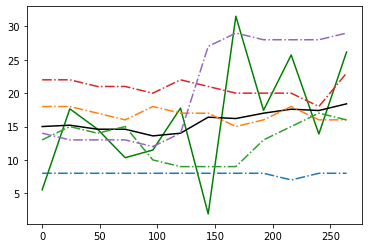

In [5]:
kk = -1
gp = supply_gps[kk]
plt.plot(Ts, gp.sample(), linestyle='-', color='g')
plt.plot(Ts, gp.mean, linestyle='-', color='k')
for ii in range(n_files):
    idx_range = range(N*ii,N*(ii+1))
    plt.plot(Ts, supply_train[kk,idx_range], linestyle='-.')

### Construct GP for demand

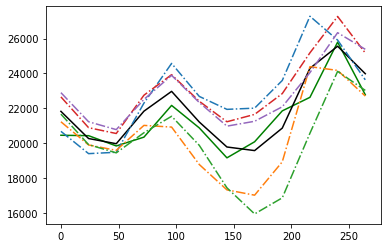

In [6]:
demand_gp = GaussianProcess()
demand_gp.train(x_train, demand_train)
demand_gp.predict(Ts, ε=1e3)

plt.plot(Ts, demand_gp.sample(), linestyle='-', color='g')
plt.plot(Ts, demand_gp.mean, linestyle='-', color='k')
for ii in range(n_files):
    idx_range = range(N*ii,N*(ii+1))
    plt.plot(Ts, demand_train[idx_range], linestyle='-.')

### Solve sample problem

In [7]:
supply = np.zeros((n_sources, N))
for ii, gp in enumerate(supply_gps):
    supply[ii] = gp.sample()
supply = np.maximum(supply, 0.0)

hour_ahead_forecast = demand_gp.sample()

In [8]:
params = {}
params['initial_storage_MW'] = initial_storage_MW
params['max_sources'] = max_sources
params['supply'] = supply
params['hour_ahead_forecast'] = hour_ahead_forecast

In [9]:
prob = Problem(N, n_sources)

In [10]:
prob_success, cost, solve_time, optvals = prob.solve_bin_problem(params)
prob_success

Academic license - for non-commercial use only - expires 2021-07-20
Using license file /Users/acauligi/gurobi.lic


True

In [11]:
y_opt = optvals[0]
prob.solve_coco_problem(params, y_opt)

(True, 367197.23033115634, 0.024890899658203125)